# Plot the model schematic of dvv components

In this notebook we plot the model schematics to compose the model formula used in MCMC inversion.

2022.05.06 Kurama Okubo


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import pickle
import h5py
import emcee # MCMC sampler
import corner
import copy

%matplotlib inline

# modules used for Low level callback function duting integration
import os, ctypes
from scipy import integrate, LowLevelCallable
import matplotlib.dates as dates
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = False # True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
output_imgdir = "./"

# Read precipitation and temperature

In [3]:
df_preciptemp = pd.read_csv("../../Post/ModelFit/data/interped_tempandprecip_longterm.csv", index_col=0)

In [4]:
df_preciptemp.loc[:, "tvec"] = pd.to_datetime(df_preciptemp["t"])

In [5]:
starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

df_preciptemp_filt = df_preciptemp[(df_preciptemp["tvec"] > starttime) & (df_preciptemp["tvec"] <  endtime)]

In [6]:
df_preciptemp_filt

,t,CAVG,precip,tvec
24,2002-01-16,-11.288114,11.393355,2002-01-16
25,2002-01-31,-11.496464,7.093677,2002-01-31
26,2002-02-15,-5.984877,2.794000,2002-02-15
27,2002-03-02,-4.825483,8.781143,2002-03-02
28,2002-03-17,-8.167028,13.199806,2002-03-17
...,...,...,...,...
516,2022-04-01,-0.224827,17.746323,2022-04-01
517,2022-04-16,-0.717417,5.401733,2022-04-16
518,2022-05-01,0.138853,2.607733,2022-05-01
519,2022-05-16,0.424987,0.000000,2022-05-16


# log healing model

In [7]:
# make time vector
date_range_st = starttime + datetime.timedelta(days=15) # stack central date
uniformdates = pd.date_range(start=date_range_st, end=endtime, freq='15D')
uniform_tvec = uniformdates.date

# timing of event

tSS = datetime.datetime(2003, 12, 22)
unix_tSS = (tSS - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') # origin of time

tPF = datetime.datetime(2004, 9, 28)
unix_tPF = (tPF - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') # origin of time

unix_tvec = np.array([x.timestamp() for x in pd.to_datetime(uniformdates.date)])

In [8]:
# Functions to compute logarithmic healing model in Snieder et al. 2017
def int1(tau, t):
    return (1/tau) * np.exp(-t/tau)

def logheal(ts, S, taumin, taumax):
#     taumin = 0.1 # fix taumin so that healing starts just after incident
    return -S*integrate.quad(int1, taumin, taumax, args=(ts))[0]
    
def y1(t, S, taumin, taumax, unix_tEV):
    '''compute time series of log hearling'''
    if t < unix_tEV:
        return 0
    else:
        # compute logheal model
        return logheal(t-unix_tEV, S, taumin, taumax)

In [9]:
S1 = 0.006
S2 = 0.03
tmin1 = 10**4.903 #[s]
tmax1 = 10*86400*365 #[s]
tmin2 = 10**6.993 #[s]
tmax2 = 10*86400*365 #[s]

y_SS = [y1(t, S1, tmin1, tmax1, unix_tSS) for t in unix_tvec]
y_PF = [y1(t, S2, tmin2, tmax2, unix_tPF) for t in unix_tvec]

# compute linear term and residual healing

In [10]:
#4. ---Linear trend---#
def compute_lineartrend(tvec, b):
    """
    return linear trend with the slope of b, whose unit is [1/day].
    """
    return b * (tvec-tvec[0])/86400 # [1/day]

#5. ---residual healing---#
def resheal_heaviside(t, unix_tEV):
    if t < unix_tEV:
        return 1
    else:
        return 0

def compute_residualhealing(tvec, c, unix_tSS):
    """
    return the residual healing before the event: cH(tev - t)
    """
    return [c * resheal_heaviside(t, unix_tSS) for t in tvec]

In [11]:
b_lin = 6e-6
c = -0.02
y_lintrend = compute_lineartrend(unix_tvec, b_lin)
y_resheal = compute_residualhealing(unix_tvec, c, unix_tSS)


# Plot master

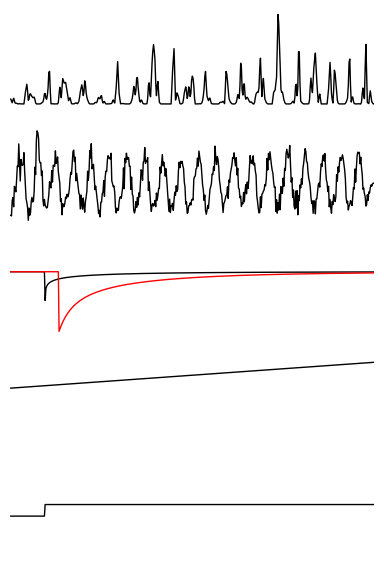

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(4, 6), sharex=True)
lw = 1
# precipitation
axs[0].plot(uniform_tvec, df_preciptemp_filt["precip"], "-", c="k", lw=lw)
# temperature

axs[1].plot(uniform_tvec, df_preciptemp_filt["CAVG"], "-", c="k", lw=lw)

# logheal
axs[2].plot(uniform_tvec, y_SS, "-", c="k", lw=lw)
axs[2].plot(uniform_tvec, y_PF, "-", c="r", lw=lw)
axs[2].set_ylim([-0.12, 0.05])

# linear trend
axs[3].plot(uniform_tvec, y_lintrend, "-", c="k", lw=lw)
axs[3].set_ylim([-0.12, 0.05])

# residual healing
axs[4].plot(uniform_tvec, y_resheal, "-", c="k", lw=lw)
axs[4].set_ylim([-0.12, 0.05])


axs[0].set_xlim([datetime.datetime(2002, 1,1), datetime.datetime(2022, 6,1)])

for i in range(5):
    axs[i].set_axis_off()

    
plt.tight_layout()
plt.savefig(output_imgdir+"/modelschematic_dvv.png", format="png", dpi=150)
plt.savefig(output_imgdir+"/modelschematic_dvv.eps", format="eps")


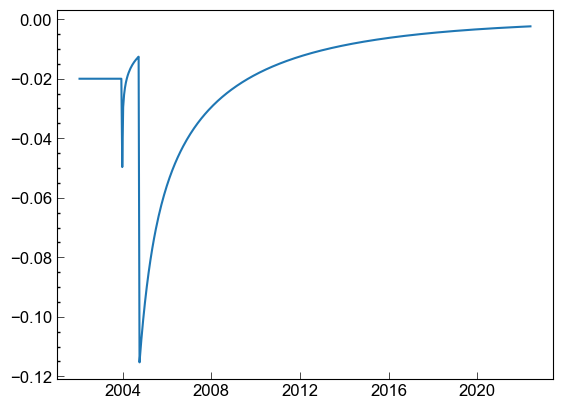

In [13]:
plt.plot(uniform_tvec, np.array(y_SS)+np.array(y_PF)+np.array(y_resheal))